### Introduction
In this note book we will do EDA on the reviews and feedback, reviews are just for food and feedback includes any feedback from food to the review for the platform.


#### Note:
* Our data for rating and feedback is very small,therefore after finishing analysisi on our data we will explore Yelp data to complete this section.

### Exploratory Analysis
To begin this exploratory analysis, first use matplotlib to import libraries and define functions for plotting the data. Depending on the data, not all plots will be made.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from nltk import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
import numpy as np
from  collections import defaultdict   
import itertools
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

Let's upload all the files


In [122]:
fpath_feedback = '../data/feedback.csv'
fpath_review = '../data/review.csv'
fpath_yelp = '../data/yelp_review_cropped.csv'

feedback = pd.read_csv (fpath_feedback)
reviews = pd.read_csv (fpath_review)
yelp = pd.read_csv (fpath_yelp)

In [64]:
nRow, nCol = feedback.shape
print(f'There are {nRow} rows and {nCol} columns for feedback')

There are 802 rows and 7 columns for feedback


In [65]:
nRow, nCol = reviews.shape
print(f'There are {nRow} rows and {nCol} columns for reviews')

There are 74 rows and 12 columns for reviews


In [66]:
nRow, nCol = yelp.shape
print(f'There are {nRow} rows and {nCol} columns for yelp reviews')

There are 9000 rows and 9 columns for yelp reviews


Let's take a quick look at what the data looks like:

In [67]:
reviews.head()

,Id,Message,Rating,CreatedDate,UserId,MenuBookItemInfoId,Status,Bitter,Salty,Savory,Sour,Sweet
0,84,rrrrrrr,4,2019-09-30T20:46:57.829856Z,1,7,3,NaN,NaN,NaN,NaN,NaN
1,76,⁦✌️⁩⁦✌️⁩👍👍😍,3,2019-07-13T04:18:21.348956Z,4,320,3,NaN,NaN,NaN,NaN,NaN
2,74,Best sooooooosis,5,2019-06-17T04:16:12.559684Z,105,320,3,NaN,NaN,NaN,NaN,NaN
3,47,Wow It is so good,5,2019-01-02T21:12:35.894906Z,8,40,3,NaN,NaN,NaN,NaN,NaN
4,44,Wow so good,4,2018-12-24T08:18:51.017771Z,8,299,3,NaN,NaN,NaN,NaN,NaN


In [68]:
feedback.head()

,Id,VirtualMenuStar,OrderingProcessStar,OnlinePaymentStar,OtherComments,UserOrderId,CreatedDate
0,802,5,5,5,NaN,14777,2022-01-16T00:43:33.844237Z
1,801,5,1,5,Food arrived 50 minutes later than the request...,14479,2021-12-08T17:26:32.295815Z
2,800,5,5,5,Smile,13892,2021-09-21T05:21:33.518309Z
3,799,5,5,5,NaN,13886,2021-09-20T02:11:48.826812Z
4,798,5,5,5,Your hammer sandwich that you say is Spicy but...,13607,2021-08-29T23:56:25.635394Z


In [69]:
yelp.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,B4sSnDIAzHUh8YSFu1LNeg,BytRWk8X1OelSgwwfXd8Aw,SNn_I8VMds60C4bSXCyUtw,5,2015-11-29,Every dish we tried was cooked to perfection w...,2,1,3
1,P22ibdsG1tryITxKEK_a4Q,BytRWk8X1OelSgwwfXd8Aw,rfa_0AOmpwLTj32RL2Zvyw,5,2014-11-06,yum yum yum!\n\nWent with a party of four - we...,1,0,1
2,SR6d_AmgGBK10ieEHsqk0Q,BytRWk8X1OelSgwwfXd8Aw,ky8BMyjQm83cqq9fx_Rn3w,3,2016-05-03,I get the whole rustic coffee shop feel that i...,2,0,0
3,ceg_wwrykBiqITCqP411kw,BytRWk8X1OelSgwwfXd8Aw,t7R-p3dhGV78dSARAFKEOA,5,2015-07-18,Amazing place for lunch.\n\nThe salads are del...,1,0,0
4,Ft62sweGiYYZyAjinuTbVg,BytRWk8X1OelSgwwfXd8Aw,NncsqhAElh0zykYdUULByg,4,2016-01-24,The standard for decor and atmosphere for Mont...,1,0,1


## 1. Sentiment Analysis for Feedback

### 1.1 Data Preprocess and Analysis

In [123]:
feedback.columns = [c.lower() for c in feedback.columns]
feedback.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   802 non-null    int64 
 1   virtualmenustar      802 non-null    int64 
 2   orderingprocessstar  802 non-null    int64 
 3   onlinepaymentstar    802 non-null    int64 
 4   othercomments        155 non-null    object
 5   userorderid          802 non-null    int64 
 6   createddate          802 non-null    object
dtypes: int64(5), object(2)
memory usage: 44.0+ KB


In [126]:
# rename the columns
feedback = feedback.rename(columns={'othercomments' : 'feedback' ,'virtualmenustar' : 'rating'})

In [125]:
feedback

,id,rating,orderingprocessstar,onlinepaymentstar,feedback,userorderid,createddate
0,802,5,5,5,NaN,14777,2022-01-16T00:43:33.844237Z
1,801,5,1,5,Food arrived 50 minutes later than the request...,14479,2021-12-08T17:26:32.295815Z
2,800,5,5,5,Smile,13892,2021-09-21T05:21:33.518309Z
3,799,5,5,5,NaN,13886,2021-09-20T02:11:48.826812Z
4,798,5,5,5,Your hammer sandwich that you say is Spicy but...,13607,2021-08-29T23:56:25.635394Z
...,...,...,...,...,...,...,...
797,5,5,5,5,NaN,1814,2020-09-03T22:12:25.146882Z
798,4,5,5,5,NaN,1807,2020-09-03T03:16:31.110117Z
799,3,4,3,2,menu is simple but easy to follow. Order proce...,1805,2020-09-03T01:47:10.453395Z
800,2,5,5,5,NaN,1800,2020-09-03T00:08:11.430936Z


In [127]:
# remove rows with null values
feedback.dropna(subset=['feedback'], inplace=True)
feedback.isnull().sum()

id                     0
rating                 0
orderingprocessstar    0
onlinepaymentstar      0
feedback               0
userorderid            0
createddate            0
dtype: int64

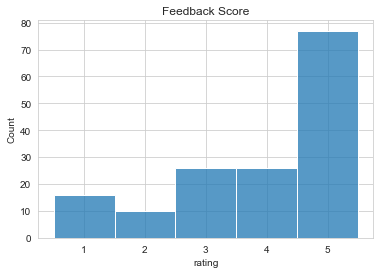

In [128]:
# plot a histogram of Scores by count
sns.set_style('whitegrid')
sns.histplot(data=feedback, x='rating', discrete=True)
plt.title('Feedback Score')
plt.show()

### Text cleaning and preprocessing

In [129]:
stopwords = set(STOPWORDS)
text = " ".join(review for review in feedback.feedback)
tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
# remove the stop words
no_stops = [t for t in tokens if t not in stopwords]
# lemmetize the words
lemmetizer = WordNetLemmatizer()
lemmetized = [lemmetizer.lemmatize(t) for t in no_stops]
Counter(lemmetized).most_common(10)

[('order', 29),
 ('food', 19),
 ('option', 16),
 ('pay', 16),
 ('time', 14),
 ('t', 12),
 ('picture', 12),
 ('tip', 12),
 ('payment', 12),
 ('menu', 11)]

<function matplotlib.pyplot.show(close=None, block=None)>

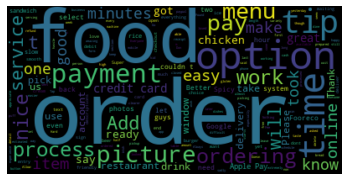

In [130]:
# plot wordcloud for the feedback
wordcloud = WordCloud(stopwords=stopwords).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show

Now we will do sentimental analysis on the comments, by consider the positive as rating over 3 and negative below 3.

In [131]:
feedback = feedback[feedback['rating'] != 3]
feedback['sentiment'] = feedback['rating'].apply(lambda rating: 1 if rating > 3 else -1)
feedback.head()

,id,rating,orderingprocessstar,onlinepaymentstar,feedback,userorderid,createddate,sentiment
1,801,5,1,5,Food arrived 50 minutes later than the request...,14479,2021-12-08T17:26:32.295815Z,1
2,800,5,5,5,Smile,13892,2021-09-21T05:21:33.518309Z,1
4,798,5,5,5,Your hammer sandwich that you say is Spicy but...,13607,2021-08-29T23:56:25.635394Z,1
5,797,5,3,2,Apparently the food got ready sooner the schde...,13490,2021-08-28T19:59:01.483751Z,1
6,796,5,3,4,KINDA OF SLOW,13007,2021-08-16T02:28:28.748844Z,1


In [132]:
# split the dataframe to posative and negative
positive = feedback[feedback['sentiment'] == 1]
negative = feedback[feedback['sentiment'] == -1]

Count the words in positive data

In [133]:
positive_summary = " ".join(review for review in positive.feedback)
tokens = [w for w in word_tokenize(positive_summary.lower()) if w.isalpha()]
no_stops = [t for t in tokens if t not in stopwords]
lemmetizer = WordNetLemmatizer()
lemmetized = [lemmetizer.lemmatize(t) for t in no_stops]
Counter(lemmetized).most_common(10)

[('time', 13),
 ('order', 13),
 ('option', 13),
 ('pay', 12),
 ('food', 11),
 ('tip', 8),
 ('process', 8),
 ('easy', 7),
 ('payment', 7),
 ('ordering', 7)]

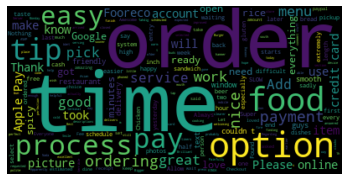

In [134]:
positive_wordcloud = WordCloud(stopwords=stopwords).generate(positive_summary)

plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [135]:
negative_summary = " ".join(review for review in negative.feedback)
tokens = [w for w in word_tokenize(negative_summary.lower()) if w.isalpha()]
no_stops = [t for t in tokens if t not in stopwords]
lemmetizer = WordNetLemmatizer()
lemmetized = [lemmetizer.lemmatize(t) for t in no_stops]
Counter(lemmetized).most_common(10)

[('order', 7),
 ('food', 6),
 ('picture', 6),
 ('t', 5),
 ('tip', 4),
 ('work', 4),
 ('chicken', 3),
 ('even', 3),
 ('dont', 3),
 ('take', 3)]

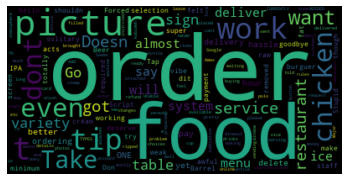

In [136]:
negative_wordcloud = WordCloud(stopwords=stopwords).generate(negative_summary)

plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

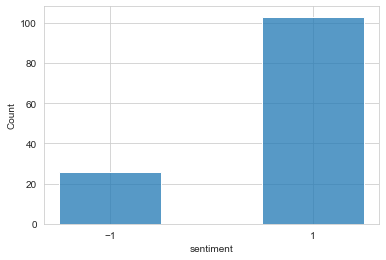

In [137]:
sns.histplot(data=feedback, x='sentiment', discrete=True)
plt.xticks([-1, 1])
plt.show()

### 1.2 Prediction Model (Classification)
Lets explore how our model will predict the new data.

In [139]:
# remove punctuation from comments if any, for better cleanup
def remove_punctuation(text):
    return "".join(c for c in text if c not in ("?", ".", ";", ":",  "!",'"'))

feedback['feedback'] = feedback['feedback'].apply(remove_punctuation)

We will explor Naive Bayes model which is proven to be the best model for sentiment analysis

In [140]:
y = feedback['sentiment']
X = feedback['feedback']

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=53)
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

nb_classifier = MultinomialNB(alpha=0.5)
nb_classifier.fit(count_train,y_train)
pred = nb_classifier.predict(count_test)


score = metrics.accuracy_score(y_test,pred)
print("Naive Bayse Score: {:2.2%}".format(score))

cm = metrics.confusion_matrix(y_test,pred)
print("\nConfusion Matrix:\n",cm)

print("\nClassification Report:\n",classification_report(y_test,pred,labels=np.unique(pred)))


Naive Bayse Score: 79.07%

Confusion Matrix:
 [[ 0  5]
 [ 4 34]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         5
           1       0.87      0.89      0.88        38

    accuracy                           0.79        43
   macro avg       0.44      0.45      0.44        43
weighted avg       0.77      0.79      0.78        43



Lets also try tfidf model for the test vectorization and fit out model.

In [85]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english",max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

# fit the model on data and predict
nb_classifier.fit(tfidf_train,y_train)
pred = nb_classifier.predict(tfidf_test)

# metrics and validation of the model
score = metrics.accuracy_score(y_test,pred)
print("Naive Bayse Score: {:2.2%}".format(score))

cm = metrics.confusion_matrix(y_test,pred,labels=[-1,1])
print("\nConfusion Matrix:\n",cm)

print("\nClassification Report:\n",classification_report(y_test,pred,labels=np.unique(pred)))

Naive Bayse Score: 88.37%

Confusion Matrix:
 [[ 0  5]
 [ 0 38]]

Classification Report:
               precision    recall  f1-score   support

           1       0.88      1.00      0.94        38

   micro avg       0.88      1.00      0.94        38
   macro avg       0.88      1.00      0.94        38
weighted avg       0.88      1.00      0.94        38



## 2. Sentiment Analysis for Reviews


### 2.1 Data Preprocess and Analysis

In [141]:
reviews.columns = [c.lower() for c in reviews.columns]
reviews.head()

,id,message,rating,createddate,userid,menubookiteminfoid,status,bitter,salty,savory,sour,sweet
0,84,rrrrrrr,4,2019-09-30T20:46:57.829856Z,1,7,3,NaN,NaN,NaN,NaN,NaN
1,76,⁦✌️⁩⁦✌️⁩👍👍😍,3,2019-07-13T04:18:21.348956Z,4,320,3,NaN,NaN,NaN,NaN,NaN
2,74,Best sooooooosis,5,2019-06-17T04:16:12.559684Z,105,320,3,NaN,NaN,NaN,NaN,NaN
3,47,Wow It is so good,5,2019-01-02T21:12:35.894906Z,8,40,3,NaN,NaN,NaN,NaN,NaN
4,44,Wow so good,4,2018-12-24T08:18:51.017771Z,8,299,3,NaN,NaN,NaN,NaN,NaN


In [142]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  74 non-null     int64  
 1   message             36 non-null     object 
 2   rating              74 non-null     int64  
 3   createddate         74 non-null     object 
 4   userid              74 non-null     int64  
 5   menubookiteminfoid  74 non-null     int64  
 6   status              74 non-null     int64  
 7   bitter              0 non-null      float64
 8   salty               3 non-null      float64
 9   savory              3 non-null      float64
 10  sour                2 non-null      float64
 11  sweet               3 non-null      float64
dtypes: float64(5), int64(5), object(2)
memory usage: 7.1+ KB


In [143]:
# remove rows with null values
reviews.dropna(subset=['message'], inplace=True)
reviews.isnull().sum()

id                     0
message                0
rating                 0
createddate            0
userid                 0
menubookiteminfoid     0
status                 0
bitter                36
salty                 36
savory                36
sour                  36
sweet                 36
dtype: int64

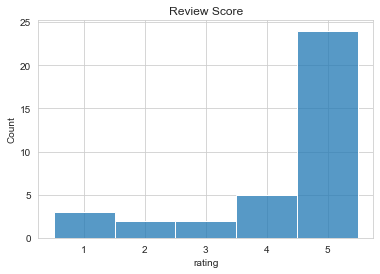

In [144]:
# plot a histogram of Scores by count
sns.set_style('whitegrid')
sns.histplot(data=reviews, x='rating', discrete=True)
plt.title('Review Score')
plt.show()

In [145]:
text = " ".join(review for review in reviews.message)
tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
no_stops = [t for t in tokens if t not in stopwords]
lemmetizer = WordNetLemmatizer()
lemmetized = [lemmetizer.lemmatize(t) for t in no_stops]
Counter(lemmetized).most_common(10)

[('good', 7),
 ('delicious', 4),
 ('best', 3),
 ('super', 3),
 ('fish', 3),
 ('wow', 2),
 ('yummy', 2),
 ('loved', 2),
 ('always', 2),
 ('love', 2)]

<function matplotlib.pyplot.show(close=None, block=None)>

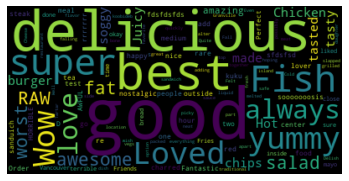

In [146]:
wordcloud = WordCloud(stopwords=stopwords).generate(text)

# plot wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show

Lets do the sentiment analysis as before. Ratings over 3 is positive and below 3 is negative.

In [147]:
reviews = reviews[reviews['rating'] != 3]
reviews['sentiment'] = reviews['rating'].apply(lambda score: 1 if score > 3 else -1)
reviews.head()

,id,message,rating,createddate,userid,menubookiteminfoid,status,bitter,salty,savory,sour,sweet,sentiment
0,84,rrrrrrr,4,2019-09-30T20:46:57.829856Z,1,7,3,NaN,NaN,NaN,NaN,NaN,1
2,74,Best sooooooosis,5,2019-06-17T04:16:12.559684Z,105,320,3,NaN,NaN,NaN,NaN,NaN,1
3,47,Wow It is so good,5,2019-01-02T21:12:35.894906Z,8,40,3,NaN,NaN,NaN,NaN,NaN,1
4,44,Wow so good,4,2018-12-24T08:18:51.017771Z,8,299,3,NaN,NaN,NaN,NaN,NaN,1
5,42,So yummy,5,2018-12-23T18:50:11.900859Z,45,299,3,NaN,NaN,NaN,NaN,NaN,1


In [148]:
# split the dataframe
positive = reviews[reviews['sentiment'] == 1]
negative = reviews[reviews['sentiment'] == -1]

In [149]:
positive_summary = " ".join(review for review in positive.message)
tokens = [w for w in word_tokenize(positive_summary.lower()) if w.isalpha()]
no_stops = [t for t in tokens if t not in stopwords]
lemmetizer = WordNetLemmatizer()
lemmetized = [lemmetizer.lemmatize(t) for t in no_stops]
Counter(lemmetized).most_common(10)

[('good', 5),
 ('delicious', 4),
 ('best', 3),
 ('wow', 2),
 ('yummy', 2),
 ('loved', 2),
 ('always', 2),
 ('love', 2),
 ('awesome', 2),
 ('tasty', 2)]

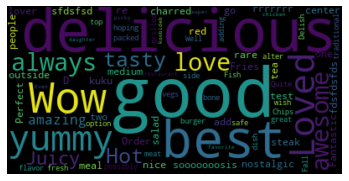

In [95]:
positive_wordcloud = WordCloud(stopwords=stopwords).generate(positive_summary)

plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [151]:
negative_summary = " ".join(review for review in negative.message)
tokens = [w for w in word_tokenize(negative_summary.lower()) if w.isalpha()]
no_stops = [t for t in tokens if t not in stopwords]
lemmetizer = WordNetLemmatizer()
lemmetized = [lemmetizer.lemmatize(t) for t in no_stops]
Counter(lemmetized).most_common(10)

[('raw', 2),
 ('super', 2),
 ('fat', 2),
 ('worst', 2),
 ('tasted', 2),
 ('fish', 2),
 ('made', 2),
 ('soggy', 2),
 ('horrible', 1),
 ('awful', 1)]

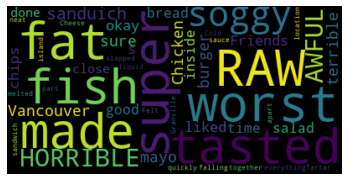

In [152]:
negative_wordcloud = WordCloud(stopwords=stopwords).generate(negative_summary)

plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

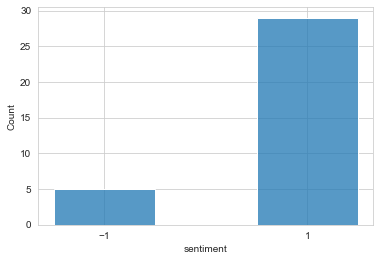

In [154]:
sns.histplot(data=reviews, x='sentiment', discrete=True)
plt.xticks([-1, 1])
plt.show()

### 2.2 Prediction Model (Classification)
Lets explore how our model will predict the new data.

In [155]:
# remove punctuation from Message
reviews['message'] = reviews['message'].apply(remove_punctuation)

In [157]:
y = reviews['sentiment']
X = reviews['message']

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=53)
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

nb_classifier = MultinomialNB(alpha=0.5)
nb_classifier.fit(count_train,y_train)
pred = nb_classifier.predict(count_test)


score = metrics.accuracy_score(y_test,pred)
print("Naive Bayse Score: {:2.2%}".format(score))

cm = metrics.confusion_matrix(y_test,pred)
print("\nConfusion Matrix:\n",cm)

print("\nClassification Report:\n",classification_report(y_test,pred,labels=np.unique(pred)))


Naive Bayse Score: 91.67%

Confusion Matrix:
 [[ 1  0]
 [ 1 10]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.50      1.00      0.67         1
           1       1.00      0.91      0.95        11

    accuracy                           0.92        12
   macro avg       0.75      0.95      0.81        12
weighted avg       0.96      0.92      0.93        12



In [158]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english",max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

# fit the model on data and predict
nb_classifier.fit(tfidf_train,y_train)
pred = nb_classifier.predict(tfidf_test)

# metrics and validation of the model
score = metrics.accuracy_score(y_test,pred)
print("Naive Bayse Score: {:2.2%}".format(score))

cm = metrics.confusion_matrix(y_test,pred,labels=[-1,1])
print("\nConfusion Matrix:\n",cm)

print("\nClassification Report:\n",classification_report(y_test,pred,labels=np.unique(pred)))

Naive Bayse Score: 91.67%

Confusion Matrix:
 [[ 0  1]
 [ 0 11]]

Classification Report:
               precision    recall  f1-score   support

           1       0.92      1.00      0.96        11

   micro avg       0.92      1.00      0.96        11
   macro avg       0.92      1.00      0.96        11
weighted avg       0.92      1.00      0.96        11



## 3. Sentiment Analysis for Yelp

### 3.1 Data Preprocess and Analysis

In [159]:
yelp.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,B4sSnDIAzHUh8YSFu1LNeg,BytRWk8X1OelSgwwfXd8Aw,SNn_I8VMds60C4bSXCyUtw,5,2015-11-29,Every dish we tried was cooked to perfection w...,2,1,3
1,P22ibdsG1tryITxKEK_a4Q,BytRWk8X1OelSgwwfXd8Aw,rfa_0AOmpwLTj32RL2Zvyw,5,2014-11-06,yum yum yum!\n\nWent with a party of four - we...,1,0,1
2,SR6d_AmgGBK10ieEHsqk0Q,BytRWk8X1OelSgwwfXd8Aw,ky8BMyjQm83cqq9fx_Rn3w,3,2016-05-03,I get the whole rustic coffee shop feel that i...,2,0,0
3,ceg_wwrykBiqITCqP411kw,BytRWk8X1OelSgwwfXd8Aw,t7R-p3dhGV78dSARAFKEOA,5,2015-07-18,Amazing place for lunch.\n\nThe salads are del...,1,0,0
4,Ft62sweGiYYZyAjinuTbVg,BytRWk8X1OelSgwwfXd8Aw,NncsqhAElh0zykYdUULByg,4,2016-01-24,The standard for decor and atmosphere for Mont...,1,0,1


In [160]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    9000 non-null   object
 1   user_id      9000 non-null   object
 2   business_id  9000 non-null   object
 3   stars        9000 non-null   int64 
 4   date         9000 non-null   object
 5   text         9000 non-null   object
 6   useful       9000 non-null   int64 
 7   funny        9000 non-null   int64 
 8   cool         9000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 632.9+ KB


In [161]:
# remove rows with null values
yelp.dropna(subset=['text'], inplace=True)
yelp.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
date           0
text           0
useful         0
funny          0
cool           0
dtype: int64

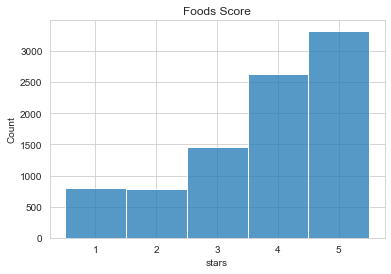

In [162]:
# plot a histogram of Scores by count
sns.set_style('whitegrid')
sns.histplot(data=yelp, x='stars', discrete=True)
plt.title('Foods Score')
plt.show()

In [163]:
text = " ".join(text for text in yelp.text)
tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
no_stops = [t for t in tokens if t not in stopwords]
lemmetizer = WordNetLemmatizer()
lemmetized = [lemmetizer.lemmatize(t) for t in no_stops]
Counter(lemmetized).most_common(10)

[('place', 5356),
 ('good', 5134),
 ('food', 4884),
 ('great', 4002),
 ('time', 3987),
 ('one', 3604),
 ('service', 3127),
 ('really', 2842),
 ('back', 2749),
 ('go', 2710)]

<function matplotlib.pyplot.show(close=None, block=None)>

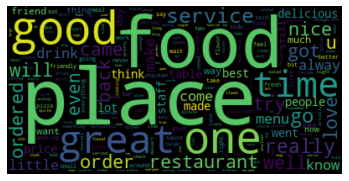

In [164]:
wordcloud = WordCloud(stopwords=stopwords).generate(text)

# plot wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show

In [168]:
yelp = yelp[yelp['stars'] != 3]
yelp['sentiment'] = yelp['stars'].apply(lambda score: 1 if score > 3 else -1)
yelp.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,Sentiment,sentiment
0,B4sSnDIAzHUh8YSFu1LNeg,BytRWk8X1OelSgwwfXd8Aw,SNn_I8VMds60C4bSXCyUtw,5,2015-11-29,Every dish we tried was cooked to perfection w...,2,1,3,1,1
1,P22ibdsG1tryITxKEK_a4Q,BytRWk8X1OelSgwwfXd8Aw,rfa_0AOmpwLTj32RL2Zvyw,5,2014-11-06,yum yum yum!\n\nWent with a party of four - we...,1,0,1,1,1
3,ceg_wwrykBiqITCqP411kw,BytRWk8X1OelSgwwfXd8Aw,t7R-p3dhGV78dSARAFKEOA,5,2015-07-18,Amazing place for lunch.\n\nThe salads are del...,1,0,0,1,1
4,Ft62sweGiYYZyAjinuTbVg,BytRWk8X1OelSgwwfXd8Aw,NncsqhAElh0zykYdUULByg,4,2016-01-24,The standard for decor and atmosphere for Mont...,1,0,1,1,1
5,Fspo02xWT7to6UE9HXwxnw,BytRWk8X1OelSgwwfXd8Aw,mkNDSH0DQlNAF4ml3MYpkg,4,2015-11-26,Stumbled upon this place when I was looking fo...,3,1,1,1,1


In [169]:
# split the dataframe
positive = yelp[yelp['sentiment'] == 1]
negative = yelp[yelp['sentiment'] == -1]

In [170]:
positive_summary = " ".join(review for review in positive.text)
tokens = [w for w in word_tokenize(positive_summary.lower()) if w.isalpha()]
no_stops = [t for t in tokens if t not in stopwords]
lemmetizer = WordNetLemmatizer()
lemmetized = [lemmetizer.lemmatize(t) for t in no_stops]
Counter(lemmetized).most_common(10)

[('place', 3451),
 ('good', 3263),
 ('great', 3186),
 ('food', 2797),
 ('time', 2459),
 ('one', 2162),
 ('service', 1874),
 ('really', 1790),
 ('will', 1665),
 ('go', 1650)]

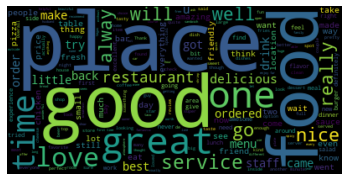

In [111]:
positive_wordcloud = WordCloud(stopwords=stopwords).generate(positive_summary)

plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [171]:
negative_summary = " ".join(review for review in negative.text)
tokens = [w for w in word_tokenize(negative_summary.lower()) if w.isalpha()]
no_stops = [t for t in tokens if t not in stopwords]
lemmetizer = WordNetLemmatizer()
lemmetized = [lemmetizer.lemmatize(t) for t in no_stops]
Counter(lemmetized).most_common(10)

[('food', 1088),
 ('place', 1005),
 ('time', 875),
 ('one', 817),
 ('service', 733),
 ('back', 715),
 ('good', 696),
 ('go', 594),
 ('u', 553),
 ('even', 529)]

In [172]:
# lets update the stopword and remove good from the words as it appears in negative ones too.
stopwords.update(['good'])

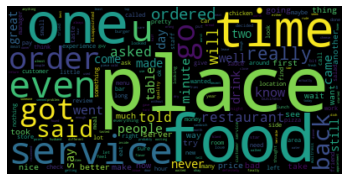

In [173]:
negative_wordcloud = WordCloud(stopwords=stopwords).generate(negative_summary)

plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

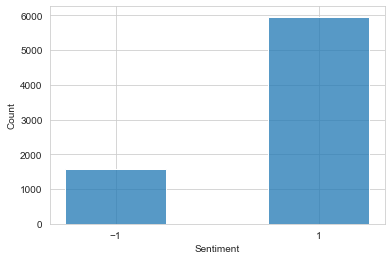

In [174]:
sns.histplot(data=yelp, x='Sentiment', discrete=True)
plt.xticks([-1, 1])
plt.show()

### 3.2 Prediction Model (Classification)
Lets explore how our model will predict the new data.

In [175]:
# remove punctuation from Summary and Text
yelp['text'] = yelp['text'].apply(remove_punctuation)

In [176]:
y = yelp['sentiment']
X = yelp['text']

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=53)
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

nb_classifier = MultinomialNB(alpha=0.5)
nb_classifier.fit(count_train,y_train)
pred = nb_classifier.predict(count_test)


score = metrics.accuracy_score(y_test,pred)
print("Naive Bayse Score: {:2.2%}".format(score))

cm = metrics.confusion_matrix(y_test,pred)
print("\nConfusion Matrix:\n",cm)

print("\nClassification Report:\n",classification_report(y_test,pred,labels=np.unique(pred)))


Naive Bayse Score: 88.27%

Confusion Matrix:
 [[ 356  170]
 [ 122 1842]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.74      0.68      0.71       526
           1       0.92      0.94      0.93      1964

    accuracy                           0.88      2490
   macro avg       0.83      0.81      0.82      2490
weighted avg       0.88      0.88      0.88      2490



In [177]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english",max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

# fit the model on data and predict
nb_classifier.fit(tfidf_train,y_train)
pred = nb_classifier.predict(tfidf_test)

# metrics and validation of the model
score = metrics.accuracy_score(y_test,pred)
print("Naive Bayse Score: {:2.2%}".format(score))

cm = metrics.confusion_matrix(y_test,pred,labels=[-1,1])
print("\nConfusion Matrix:\n",cm)

print("\nClassification Report:\n",classification_report(y_test,pred,labels=np.unique(pred)))

Naive Bayse Score: 79.72%

Confusion Matrix:
 [[  21  505]
 [   0 1964]]

Classification Report:
               precision    recall  f1-score   support

          -1       1.00      0.04      0.08       526
           1       0.80      1.00      0.89      1964

    accuracy                           0.80      2490
   macro avg       0.90      0.52      0.48      2490
weighted avg       0.84      0.80      0.72      2490



As expected model with Yelp data has a much higher score for both negative and positive reviews. Also using CountVectorizer as a transformer shows higher score(88.27%) than using TfidfVectorizer with score 79.72%.

The best solution would be to use the model with yelp data for predicting new comments sentiments on Fooreco data.